# Dataset Generation

In our analysis, we want to generate a variation of the MNIST dataset that demonstrates the settings in our paper.
First we will consider a setting with only one type of digit (i.e. a 0). We will then demonstrate how to generate
data according to a latent causal graph over the considered variables.
More specifically, consider the following continuous variables:

- color
- thickness/thinness (width)
- fractures
- swelling

Each of these will be continuously generated within a compact domain according to the causal graph:

swelling <- width <- color -> fractures

(also shown below)

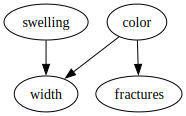

In [1]:
from graphviz import Digraph

# Create a new directed graph
dot = Digraph()

# Add nodes
dot.node('A', 'swelling')
dot.node('B', 'width')
dot.node('C', 'color')
dot.node('D', 'fractures')

# Add edges
dot.edge('A', 'B')
dot.edge('C', 'B')
dot.edge('C', 'D')

# Render the graph
dot


where the degree of swelling is inversely correlated with the width of the digit, which has a relationship with the color. The more red an image is the more wide they are, and the more fractures they have.

Now, let us actually generate the data in steps. We will leverage the MORPHO-MNIST API to generate different widths, fractures and swelling.
To modify the MNIST dataset to provide color, we will implement a variation of the IRM paper procedure.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

import numpy as np
from PIL import Image
import numpy as np
import os
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.datasets.utils as dataset_utils

import matplotlib.pyplot as plt
import seaborn as sns

KeyboardInterrupt: 

## Generate Images with different colors on the digits

In [ ]:
def color_grayscale_arr(arr, color_value):
    """Converts grayscale image to a uniform color based on a continuous value"""
    assert arr.ndim == 2
    dtype = arr.dtype
    h, w = arr.shape
    colored_arr = np.zeros((h, w, 3), dtype=dtype)
    color = plt.cm.viridis(color_value)[:3]  # Use a continuous colormap like viridis and extract RGB values
    mask = arr > 0  # Mask to identify the digit
    for i in range(3):
        colored_arr[:, :, i][mask] = color[i] * 255  # Apply uniform color to the digit
    return colored_arr.astype(dtype)

def prepare_colored_mnist(root='./data', overwrite=False):
    colored_mnist_dir = os.path.join(root, 'ColoredMNIST')
    if not overwrite and os.path.exists(os.path.join(colored_mnist_dir, 'train1.pt')) \
            and os.path.exists(os.path.join(colored_mnist_dir, 'train2.pt')) \
            and os.path.exists(os.path.join(colored_mnist_dir, 'test.pt')):
        print('Colored MNIST dataset already exists')
        return

    print('Preparing Colored MNIST')
    train_mnist = datasets.MNIST(root, train=True, download=True)

    train1_set = []
    train2_set = []
    test_set = []

    for idx, (im, label) in enumerate(train_mnist):
        if idx % 10000 == 0:
            print(f'Converting image {idx}/{len(train_mnist)}')
        im_array = np.array(im)

        # Normalize label to [0, 1] for continuous coloring
        color_value = label / 9.0
        
#         print(idx, label,color_value)
        colored_arr = color_grayscale_arr(im_array, color_value)
        
        assert False
        if idx < 20000:
            train1_set.append((Image.fromarray(colored_arr), label))
        elif idx < 40000:
            train2_set.append((Image.fromarray(colored_arr), label))
        else:
            test_set.append((Image.fromarray(colored_arr), label))

    os.makedirs(colored_mnist_dir, exist_ok=True)
    torch.save(train1_set, os.path.join(colored_mnist_dir, 'train1.pt'))
    torch.save(train2_set, os.path.join(colored_mnist_dir, 'train2.pt'))
    torch.save(test_set, os.path.join(colored_mnist_dir, 'test.pt'))

def load_colored_mnist(env='train1', root='./data'):
    colored_mnist_dir = os.path.join(root, 'ColoredMNIST')
    print(f'Loading data from colored mnist: {colored_mnist_dir}')
    if env in ['train1', 'train2', 'test']:
        data_label_tuples = torch.load(os.path.join(colored_mnist_dir, env) + '.pt')
    elif env == 'all_train':
        data_label_tuples = torch.load(os.path.join(colored_mnist_dir, 'train1.pt')) + \
                            torch.load(os.path.join(colored_mnist_dir, 'train2.pt'))
    else:
        raise RuntimeError(f'{env} env unknown. Valid envs are train1, train2, test, and all_train')
    return data_label_tuples


In [ ]:
root = '/Users/adam2392/pytorch_data/'
overwrite = True

# Prepare Colored MNIST dataset
prepare_colored_mnist(root, overwrite=overwrite)

# Load some example images
data_label_tuples = load_colored_mnist(env='train1', root=root)

# Display some example images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, (img, label) in enumerate(data_label_tuples[:5]):
    print(np.array(img).shape)
    axes[i].imshow(img)
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')
plt.show()


In [ ]:
a = np.array([[0,1]])

fig, ax = plt.subplots(figsize=(9, 1.5))
img = plt.imshow(a, cmap="viridis")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation="horizontal", cax=cax, label='Possible colors')

## Generate images with different widths using MorphoMNIST API

In [ ]:
from gendis.datasets.morphomnist import perturb, morpho
from torchvision import datasets, transforms

In [ ]:
def apply_perturbation(image, perturbation):
    # Convert image to binary
    image = image.squeeze().numpy()
    binary_image = np.array(image) > 0
#     binary_image = np.array(image.convert('L')) > 0  # Ensure the image is in grayscale and binary

    morph = morpho.ImageMorphology(binary_image)
    perturbed_image = perturbation(morph)
    return Image.fromarray((perturbed_image * 255).astype(np.uint8))

# Define the dataset loader with perturbations
class PerturbedMNIST(datasets.MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False, perturbation=None):
        super(PerturbedMNIST, self).__init__(root, train=train, transform=transform, target_transform=target_transform, download=download)
        self.perturbation = perturbation

    def __getitem__(self, index):
        img, target = super(PerturbedMNIST, self).__getitem__(index)
        if self.perturbation is not None:
            img = apply_perturbation(img, self.perturbation)
        if self.transform is not None:
            img = self.transform(img)
        
        prepare_colored_mnist(root='', overwrite=False)
    
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target


In [ ]:

# Define the perturbations
thinning = perturb.Thinning(amount=0.7)
thickening = perturb.Thickening(amount=1.0)
swelling = perturb.Swelling(strength=3, radius=10)
fracture = perturb.Fracture(thickness=1.5, prune=2, num_frac=1)

# Apply transformations and load dataset
transform = transforms.Compose([transforms.ToTensor()])
root = '/Users/adam2392/pytorch_data/'
train_dataset_thinning = PerturbedMNIST(root=root, train=True, download=True, transform=transform, perturbation=thinning)
train_dataset_thickening = PerturbedMNIST(root=root, train=True, download=True, transform=transform, perturbation=thickening)
train_dataset_swelling = PerturbedMNIST(root=root, train=True, download=True, transform=transform, perturbation=swelling)
train_dataset_fracture = PerturbedMNIST(root=root, train=True, download=True, transform=transform, perturbation=fracture)

In [ ]:

# Visualize some examples
def visualize_examples(dataset, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        img, label = dataset[i]
        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

# Display examples
# visualize_examples(train_dataset_thinning, 'Thinning Perturbation')
# visualize_examples(train_dataset_thickening, 'Thickening Perturbation')
# visualize_examples(train_dataset_swelling, 'Swelling Perturbation')
visualize_examples(train_dataset_fracture, 'Fracture Perturbation')


## Combining Color and Morpho MNIST

First, we'll look at how we can combine perturbations in a VisionDataset

In [ ]:
def apply_perturbation(image, perturbation):
    # Convert image to binary
    image = np.array(image)
    binary_image = np.array(image) > 0

    morph = morpho.ImageMorphology(binary_image)
    perturbed_image = perturbation(morph)
    return Image.fromarray((perturbed_image * 255).astype(np.uint8))


# Define the dataset loader with perturbations
class PerturbedMNIST(datasets.MNIST):
    def __init__(
        self,
        root,
        train=True,
        transform=None,
        target_transform=None,
        download=False,
        perturbations=None,
        
    ):
        super(PerturbedMNIST, self).__init__(
            root,
            train=train,
            transform=transform,
            target_transform=target_transform,
            download=download,
        )

        if perturbations is not None and not isinstance(perturbations, list):
            raise RuntimeError("Should be a list of perturbations")
        self.perturbations = perturbations

    def __getitem__(self, index):
        img, target = super(PerturbedMNIST, self).__getitem__(index)
        img = img.squeeze()
        if self.perturbations is not None:
            for perturbation in self.perturbations:
                img = torch.Tensor(np.array(img))
                img = apply_perturbation(img, perturbation)
        
        # Normalize label to [0, 1] for continuous coloring
        color_value = target / 9.0
        img = color_grayscale_arr(np.array(img), color_value)
        
#         if self.transform is not None:
#             img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    
def color_grayscale_arr(arr, color_value):
    """Converts grayscale image to a uniform color based on a continuous value"""
    assert arr.ndim == 2
    dtype = arr.dtype
    h, w = arr.shape
    colored_arr = np.zeros((h, w, 3), dtype=dtype)
    color = plt.cm.viridis(color_value)[:3]  # Use a continuous colormap like viridis and extract RGB values
    mask = arr > 0  # Mask to identify the digit
    for i in range(3):
        colored_arr[:, :, i][mask] = color[i] * 255  # Apply uniform color to the digit
    return colored_arr.astype(dtype)


In [ ]:

# Visualize some examples
def visualize_examples(dataset, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        img, label = dataset[i]
#         print('here...',
#               np.array(img).shape)
#         img = np.moveaxis(np.array(img), 0, 2)
#         print(img.shape)
        img = Image.fromarray(img)
        axes[i].imshow(img, cmap='viridis')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

perturbations = [
    perturb.Thickening(amount=0.2),
#     perturb.Swelling(strength=1.75, radius=7),
    perturb.Fracture(thickness=1.1, 
#                      prune=10, 
                     num_frac=2)
]
    
# Apply transformations and load dataset
transform = transforms.Compose([transforms.ToTensor()])
root = '/Users/adam2392/pytorch_data/'
train_dataset = PerturbedMNIST(root=root, train=True, download=False, transform=transform, perturbations=perturbations)
    
visualize_examples(train_dataset, 'All perturbations and colors')

## Full CausalMNIST on a single digit

Now, we can demonstrate CausalMNIST on a single digit "0", where we apply color, fracture and width changes in the form of a latent causal graph among these latent factors.

In [12]:
from gendis.datasets.causalmnist import CausalMNIST
from gendis.model import NonlinearNeuralClusteredASCMFlow, LinearNeuralClusteredASCMFlow

In [ ]:
graph_type = 'chain'
root = '/Users/adam2392/pytorch_data/'

dataset = CausalMNIST(root=root, graph_type=graph_type, label=0, download=True, train=True, n_jobs=None, intervention_idx=)
dataset.prepare_dataset(overwrite=True)

In [ ]:
dataset.prepare_dataset(overwrite=True)

In [ ]:

for idx in range(5):
    img, meta_label = dataset[idx]
    print(meta_label)
    
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='viridis')
    ax.set_title(f"Label: {meta_label}")
    ax.axis('off')

In [ ]:
from scipy.stats import skewnorm
import matplotlib.pyplot as plt

numValues = 10000
maxValue = 2.0
skewness = -6   #Negative values are left skewed, positive values are right skewed.

random = skewnorm.rvs(a = skewness / 2,loc=maxValue, 
                      scale=0.2,
                      size=numValues)  #Skewnorm function

random = random - min(random)      #Shift the set so the minimum value is equal to zero.
random = random / max(random) * 2      #Standadize all the vlues between 0 and 1. 
# random = random * maxValue         #Multiply the standardized values by the maximum value.

#Plot histogram to check skewness
plt.hist(random,30,density=True, color = 'red', alpha=0.1)
plt.show()

In [ ]:
from scipy.stats import skewnorm
import matplotlib.pyplot as plt

n_samples = 1000
numValues = 10000
maxValue = 10
skewness = 1   #Negative values are left skewed, positive values are right skewed.

width_intervention = stats.skewnorm.rvs(a=0, loc=2, size=(n_samples, 1))
width_intervention = width_intervention - min(width_intervention)      #Shift the set so the minimum value is equal to zero.
width = (torch.rand(size=(n_samples, 1)) * 2) * width_intervention
# width = width - min(width)
# width = width / max(width) * 2
# random = random * maxValue         #Multiply the standardized values by the maximum value.
width = width.squeeze()
print(width.shape)
#Plot histogram to check skewness
plt.hist(width,30,density=True, 
#          color = 'red', 
         alpha=0.1)
plt.show()

# Dataset Loader Demo

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from pathlib import Path
import pytorch_lightning as pl
from gendis.datasets import ClusteredMultiDistrDataModule, CausalMNIST
from gendis.model import NonlinearNeuralClusteredASCMFlow, LinearNeuralClusteredASCMFlow

In [3]:
root = "/Users/adam2392/pytorch_data/"
graph_type = 'chain'

batch_size = 32
num_workers = 2
log_dir='./'
intervention_targets_per_distr = []
hard_interventions_per_distr = None

In [4]:
datasets = []
for intervention_idx in [None, 1, 2, 3]:
    dataset = CausalMNIST(
        root=root,
        graph_type=graph_type,
        label=0,
        download=True,
        train=True,
        n_jobs=None,
        intervention_idx=intervention_idx,
    )
    dataset.prepare_dataset(overwrite=False)
    datasets.append(dataset)
    
    intervention_targets_per_distr.append(dataset.intervention_targets)

Loading dataset from "/Users/adam2392/pytorch_data/CausalMNIST/chain/chain-0-train.pt"
dict_keys(['width', 'color', 'fracture_thickness', 'fracture_num_fractures', 'label', 'intervention_targets'])
torch.Size([3, 28, 28]) {'width': tensor([0.5344]), 'color': tensor([0.3977]), 'fracture_thickness': tensor([8.9378]), 'fracture_num_fractures': tensor([1.]), 'label': 0, 'intervention_targets': [0, 0, 0]}
Loading dataset from "/Users/adam2392/pytorch_data/CausalMNIST/chain/chain-1-train.pt"
dict_keys(['width', 'color', 'fracture_thickness', 'fracture_num_fractures', 'label', 'intervention_targets'])
torch.Size([3, 28, 28]) {'width': tensor([4.0281]), 'color': tensor([0.3975]), 'fracture_thickness': tensor([9.4378]), 'fracture_num_fractures': tensor([1.]), 'label': 0, 'intervention_targets': [1, 0, 0]}
Loading dataset from "/Users/adam2392/pytorch_data/CausalMNIST/chain/chain-2-train.pt"
dict_keys(['width', 'color', 'fracture_thickness', 'fracture_num_fractures', 'label', 'intervention_targe

In [5]:
data_module = ClusteredMultiDistrDataModule(
    datasets=datasets,
    num_workers=num_workers,
    batch_size=5,
    intervention_targets_per_distr=intervention_targets_per_distr,
    log_dir=log_dir,
    flatten=True,
)

In [6]:
data_module.setup()

torch.Size([23692, 2352]) 6 torch.Size([23692]) torch.Size([23692]) torch.Size([23692])


In [11]:
def generate_list(x, n_clusters):
    quotient = x // n_clusters
    remainder = x % n_clusters
    result = [quotient] * (n_clusters - 1)
    result.append(quotient + remainder)
    return result

adjacency_matrix = np.array([[0, 1, 0], [0, 0, 1], [0, 0, 0]])
latent_dim = len(adjacency_matrix)
seed = 1234
max_epochs=2
accelerator='mps'
devices=1

n_flows = 3  # number of flows to use in nonlinear ICA model
lr_scheduler = None
lr_min = 0.0
lr = 1e-6

# Define the model
net_hidden_dim = 128
net_hidden_dim_cbn = 128
net_hidden_layers = 3
net_hidden_layers_cbn = 3
fix_mechanisms = False

model = NonlinearNeuralClusteredASCMFlow(
    cluster_sizes=generate_list(784*3, 3),
    graph=adjacency_matrix,
    intervention_targets_per_distr=intervention_targets_per_distr,
    hard_interventions_per_distr=hard_interventions_per_distr,
    n_flows=n_flows,
    n_hidden_dim=net_hidden_dim,
    n_layers=net_hidden_layers,
    lr=lr,
    lr_scheduler=lr_scheduler,
    lr_min=lr_min,
    fix_mechanisms=fix_mechanisms,
)
checkpoint_root_dir = f"{graph_type}-seed={seed}"
checkpoint_dir = Path(checkpoint_root_dir) / "default"
logger = None
wandb = False
check_val_every_n_epoch = 1
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=checkpoint_dir,
    save_top_k=3,
    monitor="train_loss",
    every_n_epochs=check_val_every_n_epoch,
)

# Train the model
trainer = pl.Trainer(
    max_epochs=max_epochs,
    logger=logger,
    devices=devices,
    callbacks=[checkpoint_callback],
    check_val_every_n_epoch=check_val_every_n_epoch,
    accelerator=accelerator,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
trainer.fit(
    model,
    datamodule=data_module,
)


  | Name    | Type                                | Params
----------------------------------------------------------------
0 | encoder | NonparametricClusteredCausalEncoder | 44.3 M
----------------------------------------------------------------
44.3 M    Trainable params
0         Non-trainable params
44.3 M    Total params
177.087   Total estimated model params size (MB)


torch.Size([23692, 2352]) 6 torch.Size([23692]) torch.Size([23692]) torch.Size([23692])
Sanity Checking: 0it [00:00, ?it/s]

/Users/adam2392/miniforge3/envs/cdrl/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/adam2392/miniforge3/envs/cdrl/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0:  50%|██████████████████████████████                              | 1/2 [00:00<00:00,  1.81it/s]torch.Size([5]) torch.Size([5, 2352]) torch.Size([5]) torch.Size([5]) torch.Size([5]) torch.Size([5]) torch.Size([5])
                                                                                                                             

/Users/adam2392/miniforge3/envs/cdrl/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   0%|                                                             | 2/4289 [00:02<1:46:30,  1.49s/it, loss=7.82e+06]

/Users/adam2392/miniforge3/envs/cdrl/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [12]:
import torch
results_dir = Path('/Users/adam2392/pytorch_data/CausalMNIST/results/')
results_dir.mkdir(exist_ok=True, parents=True)

torch.save(model, results_dir / f'trained-model-{graph_type}.pt')

# Demo Trained Model Reproducing Images

Here, we are interested in qualitatively analyzing the trained model. This will entail

In [30]:
# print(model)
print(model.encoder.)

NonparametricClusteredCausalEncoder(
  (q0): NonparametricClusteredCausalDistribution(
    (q0): MultiEnvBaseDistribution()
    (flows): ModuleList(
      (0-2): 3 x AutoregressiveRationalQuadraticSpline(
        (mprqat): MaskedPiecewiseRationalQuadraticAutoregressive(
          (autoregressive_net): MADE(
            (preprocessing): Identity()
            (initial_layer): MaskedLinear(in_features=2352, out_features=128, bias=True)
            (blocks): ModuleList(
              (0-2): 3 x MaskedResidualBlock(
                (linear_layers): ModuleList(
                  (0-1): 2 x MaskedLinear(in_features=128, out_features=128, bias=True)
                )
                (activation): ReLU()
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (final_layer): MaskedLinear(in_features=128, out_features=54096, bias=True)
          )
        )
      )
    )
  )
  (flows): ModuleList(
    (0-2): 3 x AutoregressiveRationalQuadraticSpline(
  